In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
random_state = 42

__Your ultimate task for today is to impement the `DecisionTree` class and use it to solve classification and regression problems.__

__Specifications:__
- The class inherits from `sklearn.BaseEstimator`;
- Constructor is implemented for you. It has the following parameters:
    * `max_depth` - maximum depth of the tree; `np.inf` by default
    * `min_samples_split` - minimal number of samples in the leaf to make a split; `2` by default;
    * `criterion` - criterion to select the best split; in classification one of `['gini', 'entropy']`, default `gini`; in regression `variance`;

- `fit` method takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and `y` (`numpy.array` of type float shaped `(n_objects, 1)` in regression; `numpy.array` of type int shaped `(n_objects, 1)` with class labels in classification). It works inplace and fits the `DecisionTree` class instance to the provided data from scratch.

- `predict` method takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and returns the predicted $\hat{y}$ values. In classification it is a class label for every object (the most frequent in the leaf; if several classes meet this requirement select the one with the smallest class index). In regression it is the desired constant (e.g. mean value for `variance` criterion)

- `predict_proba` method (works only for classification (`gini` or `entropy` criterion). It takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and returns the `numpy.array` of type `float` shaped `(n_objects, n_features)` with class probabilities for every object from `X`. Class $i$ probability equals the ratio of $i$ class objects that got in this node in the training set.

    
__Small recap:__

To find the optimal split the following functional is evaluated:
    
$$G(j, t) = H(Q) - \dfrac{|L|}{|Q|} H(L) - \dfrac{|R|}{|Q|} H(R),$$
    where $Q$ is the dataset from the current node, $L$ and $R$ are left and right subsets defined by the split $x^{(j)} < t$.



1. Classification. Let $p_i$ be the probability of $i$ class in subset $X$ (ratio of the $i$ class objects in the dataset). The criterions are defined as:
    
    * `gini`: Gini impurity $$H(R) = 1 -\sum_{i = 1}^K p_i^2$$
    
    * `entropy`: Entropy $$H(R) = -\sum_{i = 1}^K p_i \log(p_i)$$ (One might use the natural logarithm).
    
2. Regression. Let $y_l$ be the target value for the $R$, $\mathbf{y} = (y_1, \dots, y_N)$ – all targets for the selected dataset $X$.
    
    * `variance`: $$H(R) = \dfrac{1}{|R|} \sum_{y_j \in R}(y_j - \text{mean}(\mathbf{y}))^2$$
    
    * `mad_median`: $$H(R) = \dfrac{1}{|R|} \sum_{y_j \in R}|y_j - \text{median}(\mathbf{y})|$$
        


In [358]:
from tree import entropy, gini, variance, mad_median, DecisionTree, one_hot_encode

In [359]:
X = np.ones((4, 5), dtype=float) * np.arange(4)[:, None]
y = np.arange(4)[:, None] + np.asarray([0.2, -0.3, 0.1, 0.4])[:, None]
class_estimator = DecisionTree(max_depth=10, criterion_name='gini')

(X_l, y_l) , (X_r, y_r) = class_estimator.make_split(1, 1., X, y)
assert np.array_equal(X[:1], X_l)
assert np.array_equal(X[1:], X_r)
assert np.array_equal(y[:1], y_l)
assert np.array_equal(y[1:], y_r)

In [360]:
digits_data = load_digits().data
digits_target = load_digits().target[:, None]
X_train, X_test, y_train, y_test = train_test_split(digits_data, digits_target, test_size=0.2, 
                                                    random_state=random_state)

In [361]:
assert len(y_train.shape) == 2 and y_train.shape[0] == len(X_train)

In [362]:
class_estimator = DecisionTree(max_depth=10, criterion_name='gini')
class_estimator.fit(X_train, y_train)
ans = class_estimator.predict(X_test)
accuracy_gini = accuracy_score(y_test, ans)
print(accuracy_gini)

0.8305555555555556


In [363]:
reference = np.array([0.09027778, 0.09236111, 0.08333333, 0.09583333, 0.11944444,
       0.13888889, 0.09930556, 0.09444444, 0.08055556, 0.10555556])

In [364]:
class_estimator = DecisionTree(max_depth=10, criterion_name='entropy')
class_estimator.fit(X_train, y_train)
ans = class_estimator.predict(X_test)
accuracy_entropy = accuracy_score(y_test, ans)
print(accuracy_entropy)

0.8694444444444445


In [365]:
#assert  0.84 < accuracy_gini < 0.9
assert  0.86 < accuracy_entropy < 0.9
assert np.abs(np.sum(class_estimator.predict_proba(X_test).mean(axis=0) - reference)) < 1e-4

Now CV:

In [366]:
param_grid = {'max_depth': range(3,11), 'criterion_name': ['gini', 'entropy']}
gs = GridSearchCV(DecisionTree(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-2)

In [367]:
%%time
gs.fit(X_train, y_train)

KeyboardInterrupt: 

In [368]:
gs.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
gs.best_score_

In [ ]:
assert gs.best_params_['criterion_name'] == 'entropy'
assert 6 < gs.best_params_['max_depth'] < 9

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("The dependence of quality on the depth of the tree")
plt.plot(np.arange(3,11), gs.cv_results_['mean_test_score'][:8], label='Gini')
plt.plot(np.arange(3,11), gs.cv_results_['mean_test_score'][8:], label='Entropy')
plt.legend(fontsize=11, loc=1)
plt.xlabel("max_depth")
plt.ylabel('accuracy')
plt.show()

Now Regression:

In [369]:
regr_data = load_boston().data
regr_target = load_boston().target[:, None] # to make the targets consistent with our model interfaces
RX_train, RX_test, Ry_train, Ry_test = train_test_split(regr_data, regr_target, test_size=0.2, random_state=random_state)


In [370]:
regressor = DecisionTree(max_depth=10, criterion_name='mad_median')
regressor.fit(RX_train, Ry_train)
predictions_mad = regressor.predict(RX_test)
mse_mad = mean_squared_error(Ry_test, predictions_mad)
print(mse_mad)

20.196845548355007


In [371]:
regressor = DecisionTree(max_depth=10, criterion_name='variance')
regressor.fit(RX_train, Ry_train)
predictions_mad = regressor.predict(RX_test)
mse_var = mean_squared_error(Ry_test, predictions_mad)
print(mse_var)

21.79436827554251


In [372]:
assert 9 < mse_mad < 20
assert 8 < mse_var < 12

AssertionError: 

In [373]:
param_grid_R = {'max_depth': range(2,9), 'criterion_name': ['variance', 'mad_median']}

In [382]:
gs_R = GridSearchCV(DecisionTree(), param_grid=param_grid_R, cv=5, scoring='neg_mean_squared_error', n_jobs=-2)
gs_R.fit(RX_train, Ry_train)

GridSearchCV(cv=5, estimator=DecisionTree(), n_jobs=-2,
             param_grid={'criterion_name': ['variance', 'mad_median'],
                         'max_depth': range(2, 9)},
             scoring='neg_mean_squared_error')

In [383]:
gs_R.best_params_

{'criterion_name': 'variance', 'max_depth': 8}

In [384]:
gs_R.best_score_

-25.613969142235895

In [385]:
assert gs_R.best_params_['criterion_name'] == 'mad_median'
assert 3 < gs_R.best_params_['max_depth'] < 7

AssertionError: 

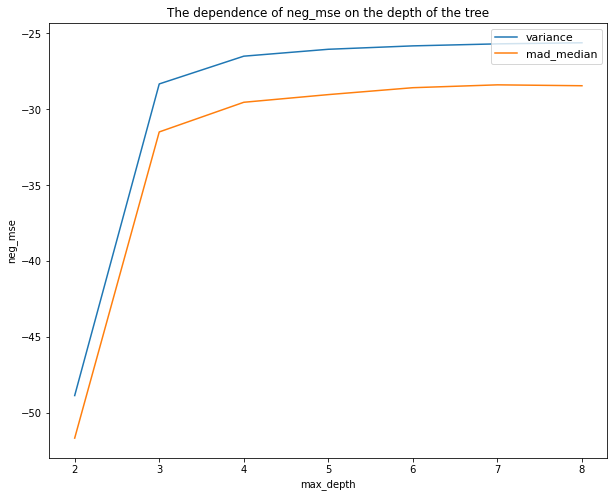

In [386]:
var_scores = gs_R.cv_results_['mean_test_score'][:7]
mad_scores = gs_R.cv_results_['mean_test_score'][7:]
plt.figure(figsize=(10, 8))
plt.title("The dependence of neg_mse on the depth of the tree")
plt.plot(np.arange(2,9), var_scores, label='variance')
plt.plot(np.arange(2,9), mad_scores, label='mad_median')
plt.legend(fontsize=11, loc=1)
plt.xlabel("max_depth")
plt.ylabel('neg_mse')
plt.show()